[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\furka\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


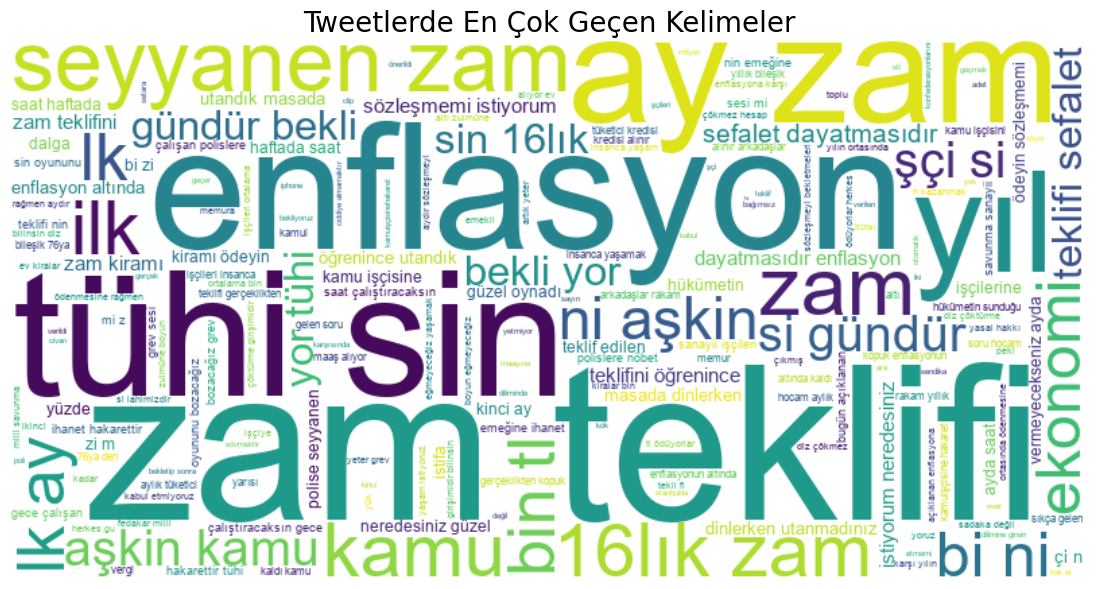

✅ Yorumlar başarıyla kaydedildi: tweet_yorum.csv


In [22]:
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


nltk.download('stopwords')

# Stopword listesi
turkce_stopwords = set(nltk_stopwords.words('turkish'))
ozel_stopwords = {
    've', 'bir', 'bu', 'da', 'de', 'için', 'ile', 'ama', 'fakat', 'ancak', 'çünkü', 'gibi',
    'mi', 'mı', 'mu', 'mü', 'ki', 'diye', 'ya', 'veya', 'ya da', 'daha', 'en', 'çok', 'az',
    'olan', 'olduğu', 'olarak', 'ise', 'yani', 'hem', 'ne', 'niçin', 'neden', 'ben', 'sen',
    'biz', 'siz', 'onlar', 'benim', 'senin', 'bizim', 'sizin', 'birçok', 'bazı', 'her', 'hiç',
    'şey', 'şu', 'o', 'tüm', 'hepsi', 'rt'
}
stopwords = turkce_stopwords.union(ozel_stopwords)


def temizle(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\sçğıöşüÇĞİÖŞÜ]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text


model_name = "savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['Negatif', 'Nötr', 'Pozitif']


def analiz_et(text, threshold=0.65):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    confidence, predicted_class = torch.max(probs, dim=1)
    if confidence.item() < threshold:
        return "Nötr", confidence.item()
    else:
        return labels[predicted_class.item()], confidence.item()

# Veri yükleme
veriler = pd.read_csv("kriz_tweetleri.csv")  # içinde 'tarih' ve tweet metin sütunu olduğunu varsayıyorum
veriler['tarih'] = pd.to_datetime(veriler['tarih'])


temiz_tweetler = []
for tweet in veriler['metin']: 
    temiz = temizle(tweet)
    kelimeler = temiz.split()
    filtreli = [k for k in kelimeler if k not in stopwords]
    temiz_tweetler.append(" ".join(filtreli))


tum_metin = " ".join(temiz_tweetler)
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='arial.ttf').generate(tum_metin)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Tweetlerde En Çok Geçen Kelimeler", fontsize=20)
plt.show()


duygu_sonuclari = []
for tweet in temiz_tweetler:
    duygu, guven = analiz_et(tweet)
    duygu_sonuclari.append({'tweet': tweet, 'duygu': duygu, 'guven': guven})

df_duygu = pd.DataFrame(duygu_sonuclari)


puan_map = {'Negatif': 0, 'Nötr': 1, 'Pozitif': 2}
df_duygu['duygu_puani'] = df_duygu['duygu'].map(puan_map)


df_duygu['tarih'] = veriler['tarih'].values


gunluk_ortalama = df_duygu.groupby(df_duygu['tarih'].dt.date)['duygu_puani'].mean().reset_index()
gunluk_ortalama.columns = ['tarih', 'ortalama_duygu_puani']


def yorumla_csv_yaz(puan):
    if puan < 1:
        return "Genel olarak olumsuz bir hava hakim."
    elif puan < 1.5:
        return "Duygular nötr seviyede."
    else:
        return "Pozitif bir hava gözlemleniyor."

gunluk_ortalama['yorum'] = gunluk_ortalama['ortalama_duygu_puani'].apply(yorumla_csv_yaz)

import os
os.makedirs("data/twitter", exist_ok=True)

gunluk_ortalama.to_csv("tweet_yorum.csv", index=False, encoding="utf-8-sig")

print("✅ Yorumlar başarıyla kaydedildi: tweet_yorum.csv")


